## Implement LambdaMART using `lightgbm`

In [1]:
!ls ../data/MSLR-WEB10K/Fold1/

test.txt  train.txt vali.txt


In [2]:
!tail -n1 ../data/MSLR-WEB10K/Fold1/train.txt

1 qid:29992 1:2 2:1 3:1 4:0 5:2 6:1 7:0.50000 8:0.50000 9:0 10:1 11:1066 12:3 13:11 14:6 15:1086 16:19.036284 17:28.261942 18:27.090498 19:29.47176 20:19.017721 21:43 22:1 23:2 24:0 25:46 26:1 27:0 28:0 29:0 30:1 31:42 32:1 33:2 34:0 35:45 36:21.50000 37:0.50000 38:1 39:0 40:23 41:420.25000 42:0.25000 43:1 44:0 45:484 46:0.040338 47:0.333333 48:0.181818 49:0 50:0.042357 51:0.000938 52:0 53:0 54:0 55:0.000921 56:0.03940 57:0.333333 58:0.181818 59:0 60:0.041436 61:0.020169 62:0.166667 63:0.090909 64:0 65:0.021179 66:0.00037 67:0.027778 68:0.008264 69:0 70:0.00041 71:390.814899 72:12.674474 73:26.489059 74:0 75:417.257951 76:9.968513 77:0 78:0 79:0 80:9.966807 81:380.846387 82:12.674474 83:26.489059 84:0 85:407.291145 86:195.40745 87:6.337237 88:13.244529 89:0 90:208.628976 91:34387.599318 92:40.160576 93:175.417555 94:0 95:39466.657481 96:1 97:0 98:0 99:0 100:1 101:0.692028 102:0.632181 103:0.691352 104:0 105:0.69019 106:38.177038 107:13.909696 108:17.007937 109:0 110:38.287432 111:-11.4

In [3]:
from glob import glob

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import ndcg_score

In [4]:
def format_data(type_):
    files = glob("../data/MSLR-WEB10K/Fold*/{}.txt".format(type_))
    labels = []
    features = []
    groups = []
    grp_cnt = 0
    for file in files:
        with open(file, "r") as fin:
            for i, line in enumerate(fin):
                label, qid, feats = line.split(" ", 2)
                labels.append(int(label))
                qid = int(qid.split(":")[-1])
                if i == 0:
                    last_qid = qid
                feats = [float(f.split(":")[-1]) for f in feats.strip().split(" ")]
                features.append(feats)
                if qid != last_qid:
                    last_qid = qid
                    groups.append(grp_cnt)
                    grp_cnt = 1
                else:
                    grp_cnt += 1
    groups.append(grp_cnt)
    return (np.array(features), np.array(labels), np.array(groups))

In [5]:
train_features, train_labels, train_groups = format_data("train")

In [6]:
len(train_features), len(train_labels), sum(train_groups)

(3600576, 3600576, 3600576)

In [7]:
train_groups

array([103,  76, 102, ...,  79, 180,  40])

In [8]:
test_features, test_labels, test_groups = format_data("test")

In [9]:
len(test_features), len(test_labels), sum(test_groups)

(1200192, 1200192, 1200192)

In [10]:
train_data = lgb.Dataset(
    data=train_features,
    label=train_labels,
    group=train_groups,
    categorical_feature=None,
)
test_data = lgb.Dataset(
    data=test_features, label=test_labels, group=test_groups, categorical_feature=None
)

In [11]:
import optuna
from optuna.integration import LightGBMPruningCallback

In [12]:
def objective(trial, data):
    params = {
        "task": "train",
        "objective": "lambdarank",
        "metric": "ndcg",
        "ndcg_eval_at": [10, 5, 1],
        "num_threads": 4,
        "feature_pre_filter": False,
        "reg_alpha": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 1),
        #'subsample': trial.suggest_uniform('subsample', 1e-8, 1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
        "min_sum_hessian_in_leaf": trial.suggest_loguniform(
            "min_sum_hessian_in_leaf", 1e-8, 10.0
        ),
        "learning_rate": trial.suggest_float("learning_rate", 1e-1, 3e-1),
    }

    cv_results = lgb.cv(
        params,
        data,
        num_boost_round=100,
        nfold=3,
        callbacks=[
            lgb.log_evaluation(10),
            lgb.early_stopping(
                stopping_rounds=5, first_metric_only=True, verbose=False
            ),
        ],
    )

    return cv_results["ndcg@10-mean"][-1]


study = optuna.create_study(direction="maximize", study_name="LGBM Ranking")
func = lambda trial: objective(trial, train_data)
study.optimize(func, n_trials=5)

[I 2022-07-28 14:08:17,599] A new study created in memory with name: LGBM Ranking


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.217973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25566
[LightGBM] [Info] Number of data points in the train set: 2400384, number of used features: 136
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.219382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25566
[LightGBM] [Info] Number of data points in the train set: 2400384, number of used features: 136
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.217803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25566
[LightGBM] [Info

[I 2022-07-28 14:10:17,451] Trial 0 finished with value: 0.5318225691309834 and parameters: {'lambda_l1': 0.0007201780528750545, 'lambda_l2': 0.0006264673728298523, 'max_depth': 6, 'num_leaves': 253, 'colsample_bytree': 0.2599385883012181, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 0.027405563434297307, 'learning_rate': 0.11613801966219398}. Best is trial 0 with value: 0.5318225691309834.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.362337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25566
[LightGBM] [Info] Number of data points in the train set: 2400384, number of used features: 136
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.367967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25566
[LightGBM] [Info] Number of data points in the train set: 2400384, number of used features: 136
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.372078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25566
[LightGBM] [Info

[I 2022-07-28 14:11:38,450] Trial 1 finished with value: 0.5010600180351363 and parameters: {'lambda_l1': 7.460311684609022e-08, 'lambda_l2': 6.511336710862945e-06, 'max_depth': 3, 'num_leaves': 47, 'colsample_bytree': 0.8668065647086005, 'min_data_in_leaf': 98, 'min_sum_hessian_in_leaf': 0.007875076022252354, 'learning_rate': 0.2493246989180067}. Best is trial 0 with value: 0.5318225691309834.


[100]	cv_agg's ndcg@1: 0.498254 + 0.00145081	cv_agg's ndcg@5: 0.484569 + 0.00172201	cv_agg's ndcg@10: 0.50106 + 0.00113985
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.385182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25566
[LightGBM] [Info] Number of data points in the train set: 2400384, number of used features: 136
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.379351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25566
[LightGBM] [Info] Number of data points in the train set: 2400384, number of used features: 136
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.378450 seconds.
You can set `force_row_wise=true` to remove the ov

[I 2022-07-28 14:13:32,674] Trial 2 finished with value: 0.5773672551033014 and parameters: {'lambda_l1': 5.755679568086744e-06, 'lambda_l2': 1.255209512008629e-07, 'max_depth': 7, 'num_leaves': 251, 'colsample_bytree': 0.838672128467453, 'min_data_in_leaf': 67, 'min_sum_hessian_in_leaf': 0.1274435441067266, 'learning_rate': 0.2684268528332006}. Best is trial 2 with value: 0.5773672551033014.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.407779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25566
[LightGBM] [Info] Number of data points in the train set: 2400384, number of used features: 136
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.399589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25566
[LightGBM] [Info] Number of data points in the train set: 2400384, number of used features: 136
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.398551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25566
[LightGBM] [Info

[I 2022-07-28 14:14:46,033] Trial 3 finished with value: 0.49781673850806457 and parameters: {'lambda_l1': 1.0083834993307791e-08, 'lambda_l2': 0.0006488629962555027, 'max_depth': 3, 'num_leaves': 247, 'colsample_bytree': 0.8581550590586035, 'min_data_in_leaf': 54, 'min_sum_hessian_in_leaf': 4.4689933231897405e-08, 'learning_rate': 0.24816230074698328}. Best is trial 2 with value: 0.5773672551033014.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.314890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25566
[LightGBM] [Info] Number of data points in the train set: 2400384, number of used features: 136
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.310235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25566
[LightGBM] [Info] Number of data points in the train set: 2400384, number of used features: 136
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.320511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25566
[LightGBM] [Info

[I 2022-07-28 14:15:27,519] Trial 4 finished with value: 0.46201445588522105 and parameters: {'lambda_l1': 0.01044944869421394, 'lambda_l2': 1.7312805248626896e-08, 'max_depth': 3, 'num_leaves': 157, 'colsample_bytree': 0.5398167628344562, 'min_data_in_leaf': 85, 'min_sum_hessian_in_leaf': 2.2247305180255224e-07, 'learning_rate': 0.13326474297573135}. Best is trial 2 with value: 0.5773672551033014.


In [13]:
print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value: 0.57737
	Best params:
		lambda_l1: 5.755679568086744e-06
		lambda_l2: 1.255209512008629e-07
		max_depth: 7
		num_leaves: 251
		colsample_bytree: 0.838672128467453
		min_data_in_leaf: 67
		min_sum_hessian_in_leaf: 0.1274435441067266
		learning_rate: 0.2684268528332006


In [14]:
param = {
    "task": "train",
    "num_leaves": 255,
    "min_data_in_leaf": 1,
    "min_sum_hessian_in_leaf": 100,
    "objective": "lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at": [1, 3, 5, 10],
    "learning_rate": 0.1,
    "num_threads": 4,
}
param.update(study.best_params)

res = {}
bst = lgb.train(
    param,
    train_data,
    valid_sets=[test_data],
    valid_names=["valid"],
    num_boost_round=1000,
    callbacks=[
        lgb.record_evaluation(res),
        lgb.log_evaluation(100),
        lgb.early_stopping(stopping_rounds=5),
    ],
)

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.582483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25566
[LightGBM] [Info] Number of data points in the train set: 3600576, number of used features: 136
[LightGBM] [Warning] Unknown parameter: importance_type


/Users/felicildaloveme/miniforge3/envs/conda_py39/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [35]:
max(res["valid"]["ndcg@10"])

0.8511093436937487

In [15]:
pd.DataFrame(res["valid"]).tail()

,ndcg@1,ndcg@3,ndcg@5,ndcg@10
995,0.907445,0.881567,0.867627,0.850418
996,0.907445,0.881723,0.867786,0.850618
997,0.907595,0.881785,0.867976,0.850948
998,0.907715,0.881992,0.868123,0.851035
999,0.907773,0.882092,0.868363,0.851109


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

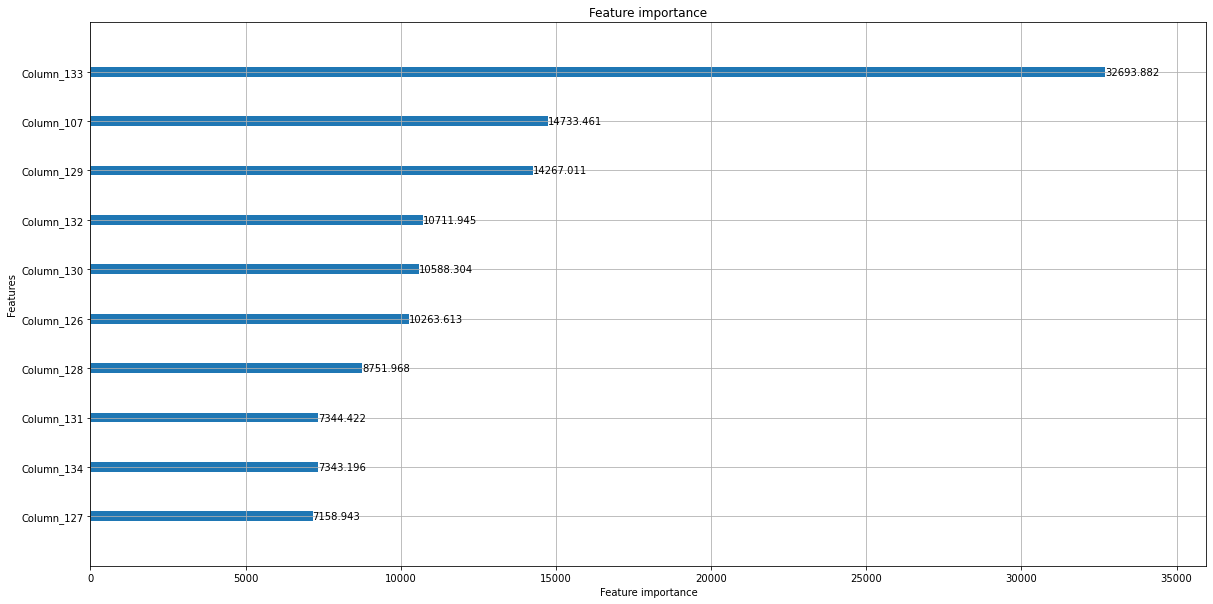

In [40]:
lgb.plot_importance(bst, importance_type="gain", figsize=(20, 10), max_num_features=10)

In [41]:
!tail -n3 ../data/MSLR-WEB10K/Fold1/vali.txt

1 qid:29995 1:1 2:0 3:0 4:0 5:1 6:0.50000 7:0 8:0 9:0 10:0.50000 11:439 12:0 13:19 14:12 15:470 16:27.896604 17:32.206631 18:31.723366 19:31.997173 20:27.894259 21:1 22:0 23:0 24:0 25:1 26:0 27:0 28:0 29:0 30:0 31:1 32:0 33:0 34:0 35:1 36:0.50000 37:0 38:0 39:0 40:0.50000 41:0.25000 42:0 43:0 44:0 45:0.25000 46:0.002278 47:0 48:0 49:0 50:0.002128 51:0 52:0 53:0 54:0 55:0 56:0.002278 57:0 58:0 59:0 60:0.002128 61:0.001139 62:0 63:0 64:0 65:0.001064 66:0.000001 67:0 68:0 69:0 70:0.000001 71:9.475923 72:0 73:0 74:0 75:9.473578 76:0 77:0 78:0 79:0 80:0 81:9.475923 82:0 83:0 84:0 85:9.473578 86:4.737962 87:0 88:0 89:0 90:4.736789 91:22.448281 92:0 93:0 94:0 95:22.437171 96:0 97:0 98:0 99:0 100:0 101:0.471409 102:0 103:0 104:0 105:0.471318 106:12.985653 107:0 108:0 109:0 110:12.740497 111:-7.28838 112:-2.813407 113:-3.768915 114:-3.976556 115:-7.35661 116:-7.799037 117:-7.60278 118:-7.606904 119:-7.608572 120:-7.811665 121:-6.189852 122:-1.714798 123:-2.67031 124:-2.877949 125:-6.258085 126:

In [42]:
vali_features, vali_labels, vali_groups = format_data("vali")

In [43]:
vali_groups = [[i] * g for i, g in enumerate(vali_groups)]
vali_groups = [i for g in vali_groups for i in g]

In [44]:
predictions = bst.predict(vali_features)

In [45]:
predict_df = pd.DataFrame(
    {
        "query_id": vali_groups,
        "true_label": vali_labels,
        "predicted": predictions,
    }
)

In [46]:
predict_df.head()

,query_id,true_label,predicted
0,0,2,-0.285701
1,0,1,-1.136885
2,0,3,-2.581324
3,0,1,0.341183
4,0,0,-1.911878


In [47]:
ndcg_score(
    predict_df[["true_label", "query_id"]], predict_df[["predicted", "query_id"]], k=10
)

0.9999406756841208